In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Домашнее задание к занятию "Алгоритмы классификации: линейные методы, логистическая регрессия и SVM"
Преподаватель: Алексей Кузьмин
Имеются данные adult.csv (см. в материалах к занятию)

Целевой переменной является уровень дохода income (крайний правый столбец).

Описание признаков можно найти по ссылке http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

Вам необходимо построить модель логистической регрессии, которая предсказывает уровень дохода человека. При возможности попробуйте улучшить точность предсказаний (метод score) с помощью перебора признаков.

Attribute Information:
* age: continuous.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* fnlwgt: continuous.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* education-num: continuous.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* sex: Female, Male.
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
* class: >50K, <=50K

## Работа с данными

Загрузим данные

In [2]:
ds = pd.read_csv('adult.csv')
print(ds.shape)
ds.head()

(48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Переведём целевую переменную в бинарный вид

In [3]:
ds['income_big'] = ds['income']=='>50K'
ds['income_big'].mean()

0.23928176569346055

In [4]:
ds.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'income_big'],
      dtype='object')

Пропущенных значений нет

In [5]:
ds.isnull().sum().sum()

0

Посмотрим на количество значений в переменных - категориальные они или вещественные

In [6]:
ds.nunique().sort_values(ascending=False)

fnlwgt             28523
capital-gain         123
capital-loss          99
hours-per-week        96
age                   74
native-country        42
educational-num       16
education             16
occupation            15
workclass              9
marital-status         7
relationship           6
race                   5
income_big             2
income                 2
gender                 2
dtype: int64

Переведём признак пола в бинарный формат

In [7]:
ds['gender-male']= ds['gender']=='Male'

## Базовая модель

Определим переменные для предсказания

In [8]:
feats = ds.drop(['income', 'income_big'],1).columns
real_feats = [
    'fnlwgt','capital-gain','capital-loss','hours-per-week','age',
    'educational-num', 'gender-male'
]
y_feat = 'income_big'
cat_feats = list(set(feats)-set(real_feats))

Выделим X и Y, произведём ohe hot encoding категориальных признаков

In [9]:
Y = ds[y_feat]

In [10]:
X = ds[real_feats]
for f in cat_feats:
    for v in ds[f].drop_duplicates().values:
        X[f'{f}_{v}'] = (ds[f]==v).astype(int)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Масштабируем признаки

In [11]:
X_scal = X.copy()
X_scal[real_feats] = StandardScaler().fit_transform(X_scal[real_feats])

Делим на train и test

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scal, Y, random_state=42)

Обучение модели

In [13]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
preds_train, preds_test = lr.predict(X_train), lr.predict(X_test)

/opt/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Расчёт метрик качества

In [14]:
res_ds = pd.DataFrame()

for m in [accuracy_score, precision_score, recall_score, roc_auc_score]:
    res = {'model':'base', 'metric':m.__name__, 'train':m(Y_train, preds_train), 'test':m(Y_test, preds_test)}
    res_ds = res_ds.append(res, ignore_index=True)

res_ds

,metric,model,test,train
0,accuracy_score,base,0.858652,0.851410
1,precision_score,base,0.739314,0.735306
2,recall_score,base,0.611481,0.599320
3,roc_auc_score,base,0.772813,0.765399


In [15]:
res_ds_base = res_ds.copy()

## Отбор лучших признаков c помощью перебора

Подготовим все признаки к работе. Затем будем выбирать только нужные

In [16]:
feats = ds.drop(['income', 'income_big'],1).columns
real_feats = [
    'fnlwgt','capital-gain','capital-loss','hours-per-week','age',
    'educational-num', 'gender-male'
]
y_feat = 'income_big'
cat_feats = list(set(feats)-set(real_feats))

In [17]:
Y = ds[y_feat]

In [18]:
X = ds[real_feats]
for f in cat_feats:
    for v in ds[f].drop_duplicates().values:
        X[f'{f}_{v}'] = (ds[f]==v).astype(int)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
X_scal = X.copy()
X_scal[real_feats] = StandardScaler().fit_transform(X_scal[real_feats])
X_train_full, X_test_full, Y_train, Y_test = train_test_split(X_scal, Y, random_state=42)

In [20]:
from itertools import combinations, chain

In [21]:
from tqdm import tqdm_notebook

Выделим комбинации из 1,5,10 признаков

In [22]:
combs = []
for i in [1,5,10]:
    combs += list(combinations(feats, i))
combs

[('age',),
 ('workclass',),
 ('fnlwgt',),
 ('education',),
 ('educational-num',),
 ('marital-status',),
 ('occupation',),
 ('relationship',),
 ('race',),
 ('gender',),
 ('capital-gain',),
 ('capital-loss',),
 ('hours-per-week',),
 ('native-country',),
 ('gender-male',),
 ('age', 'workclass', 'fnlwgt', 'education', 'educational-num'),
 ('age', 'workclass', 'fnlwgt', 'education', 'marital-status'),
 ('age', 'workclass', 'fnlwgt', 'education', 'occupation'),
 ('age', 'workclass', 'fnlwgt', 'education', 'relationship'),
 ('age', 'workclass', 'fnlwgt', 'education', 'race'),
 ('age', 'workclass', 'fnlwgt', 'education', 'gender'),
 ('age', 'workclass', 'fnlwgt', 'education', 'capital-gain'),
 ('age', 'workclass', 'fnlwgt', 'education', 'capital-loss'),
 ('age', 'workclass', 'fnlwgt', 'education', 'hours-per-week'),
 ('age', 'workclass', 'fnlwgt', 'education', 'native-country'),
 ('age', 'workclass', 'fnlwgt', 'education', 'gender-male'),
 ('age', 'workclass', 'fnlwgt', 'educational-num', 'mar

In [23]:
import warnings

In [24]:
warnings.filterwarnings('ignore')

In [25]:
comb_ds = []
for idx, c in tqdm_notebook(enumerate(combs), total=len(combs)):
    #if idx>5:
    #    break
    cols = [x for x in X_scal.columns if (x.split('_')[0] if '_' in x else x) in c ]
    X_train, X_test = X_train_full[cols], X_test_full[cols]
        
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train, Y_train)
    preds_train, preds_test = lr.predict(X_train), lr.predict(X_test)
    
    res_ds = pd.DataFrame()
    for m in [accuracy_score, precision_score, recall_score, roc_auc_score]:
        for f in c:
            res = pd.Series({'metric':m.__name__, 'part':'train',
                   'value':m(Y_train, preds_train),'feature':f, 'model':idx})
            comb_ds.append(res)
        
            res = pd.Series({'metric':m.__name__, 'part':'test',
                   'value':m(Y_test, preds_test),'feature':f, 'model':idx})
            comb_ds.append(res)
            
comb_ds = pd.concat(comb_ds, 1).T
comb_ds[['value','model']] = comb_ds[['value','model']].astype(float)

In [26]:
comb_ds.to_csv('combinations.csv')

Посмотрим на важность переменных на обучающем датасете среди разных моделей

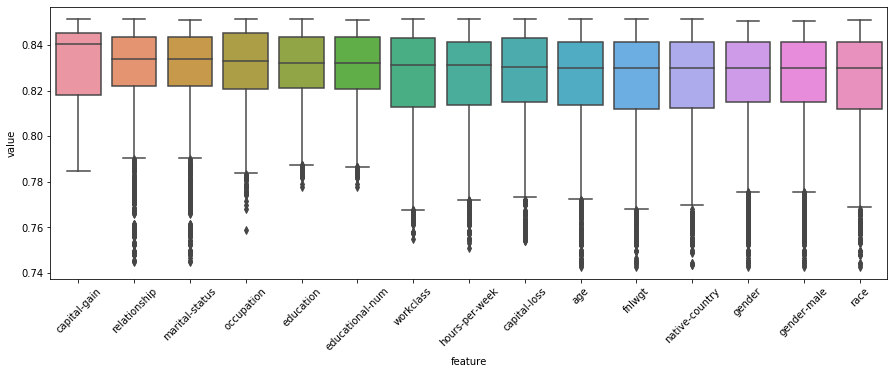

In [27]:
plt.figure(figsize=(15,5))
cds = comb_ds[(comb_ds['metric']=='accuracy_score')&(comb_ds['part']=='train')]
d = cds.groupby('feature')['value'].median().to_dict()
cds['mean_value'] = cds['feature'].apply(lambda x: d[x])
cds = cds.sort_values('mean_value', ascending=False)
plt.xticks(rotation=45)
sns.boxplot(x='feature', y='value', data=cds)

Не очень информативно

Распределение качества моделей

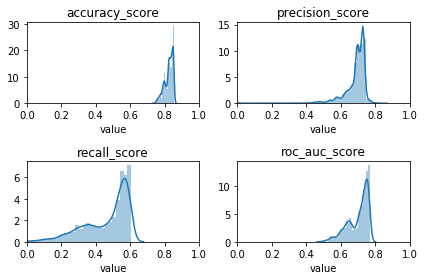

In [28]:
for idx, m in enumerate(comb_ds['metric'].drop_duplicates().values):
    plt.subplot(2, 2, idx+1)
    cds = comb_ds[comb_ds['metric']==m].groupby('model')['value'].mean()
    sns.distplot(cds)
    plt.title(m)
    plt.xlim((0,1))
plt.tight_layout()
plt.show()

Данные для лучшей модели

In [29]:
best_model = comb_ds[comb_ds['metric']=='accuracy_score'].sort_values(
    'value', ascending=False)['model'].values[0]
comb_ds[comb_ds['model']==best_model]

,metric,part,value,feature,model
360080,accuracy_score,train,0.847888,educational-num,6016.0
360081,accuracy_score,test,0.860617,educational-num,6016.0
360082,accuracy_score,train,0.847888,marital-status,6016.0
360083,accuracy_score,test,0.860617,marital-status,6016.0
360084,accuracy_score,train,0.847888,occupation,6016.0
360085,accuracy_score,test,0.860617,occupation,6016.0
360086,accuracy_score,train,0.847888,relationship,6016.0
360087,accuracy_score,test,0.860617,relationship,6016.0
360088,accuracy_score,train,0.847888,gender,6016.0
360089,accuracy_score,test,0.860617,gender,6016.0


In [30]:
c = comb_ds[comb_ds['model']==best_model]['feature'].drop_duplicates().values
c

array(['educational-num', 'marital-status', 'occupation', 'relationship',
       'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
       'native-country', 'gender-male'], dtype=object)

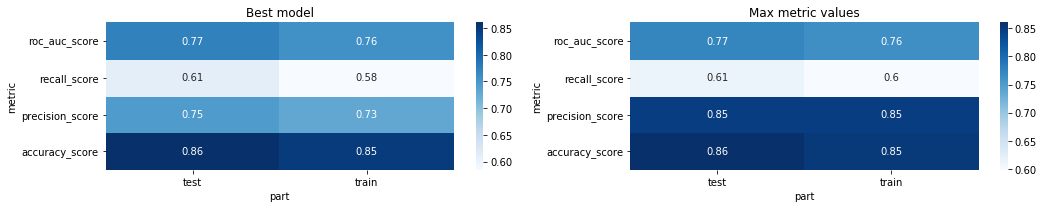

In [31]:
plt.figure(figsize=(15,3))
plt.subplot(121)
cds = comb_ds[comb_ds['model']==best_model].pivot_table(index='metric',columns='part', values='value')
sns.heatmap(cds, annot=True, cmap='Blues')
plt.ylim((0,4))
plt.title('Best model')

plt.subplot(122)
cds = comb_ds.pivot_table(index='metric',columns='part', values='value', aggfunc='max')
sns.heatmap(cds, annot=True, cmap='Blues')
plt.ylim((0,4))
plt.title('Max metric values')

plt.tight_layout()
plt.show()

Лучшая модель обладает наилучшими roc_auc_score, recall_score и accuracy_score. Проигрывает лишь в precision.

Восстановим лучшую модель

In [32]:
cols = [x for x in X_scal.columns if (x.split('_')[0] if '_' in x else x) in c ]
X_train, X_test = X_train_full[cols], X_test_full[cols]

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, Y_train)
preds_train, preds_test = lr.predict(X_train), lr.predict(X_test)

Важность признаков лучшей модели

In [33]:
feat_imps = pd.Series(lr.coef_[0], index=X_train.columns).reset_index()
feat_imps.columns = ['feature','coef']
feat_imps['feature_base'] = [x.split('_')[0] if '_' in x else x for x in feat_imps['feature']]
d = feat_imps.groupby('feature_base')['coef'].mean().to_dict()
feat_imps['mean_coef'] = feat_imps['feature_base'].apply(lambda x: d[x])
feat_imps['coef_abs'] = np.abs(feat_imps['coef'])
d = feat_imps.groupby('feature_base')['coef_abs'].mean().to_dict()
feat_imps['mean_coef_abs'] = feat_imps['feature_base'].apply(lambda x: d[x])

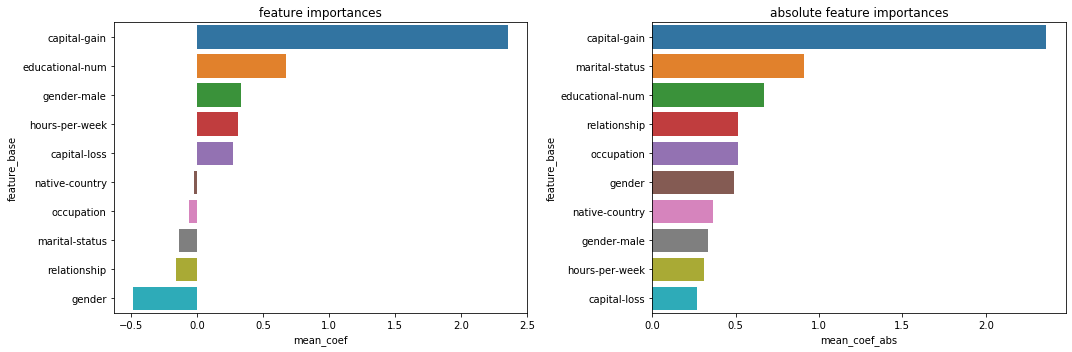

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(121)
cds = feat_imps[['feature_base','mean_coef']].drop_duplicates().sort_values('mean_coef',ascending=False)
sns.barplot(x='mean_coef', y='feature_base', data=cds)
plt.title('feature importances')

plt.subplot(122)
cds = feat_imps[['feature_base','mean_coef_abs']].drop_duplicates().sort_values('mean_coef_abs', ascending=False)
sns.barplot(x='mean_coef_abs', y='feature_base', data=cds)
plt.title('absolute feature importances')

plt.tight_layout()
plt.show()

Расчёт метрик

In [35]:
res_ds = pd.DataFrame()

for m in [accuracy_score, precision_score, recall_score, roc_auc_score]:
    res = {'model':'best', 'metric':m.__name__, 'train':m(Y_train, preds_train), 'test':m(Y_test, preds_test)}
    res_ds = res_ds.append(res, ignore_index=True)

res_ds_best = res_ds.copy()

## Сокращённая модель

Выберем самые важные признаки модели

In [36]:
feat_imps['feature_base'].drop_duplicates()

0        capital-gain
1        capital-loss
2      hours-per-week
3     educational-num
4         gender-male
5              gender
7        relationship
13     native-country
55     marital-status
62         occupation
Name: feature_base, dtype: object

In [37]:
cds = feat_imps[['feature_base','mean_coef_abs']].drop_duplicates().sort_values('mean_coef_abs')
cds['mean_coef_abs'] /= cds['mean_coef_abs'].sum()
#cds = cds[cds['mean_coef_abs']>=0.05]
cds

,feature_base,mean_coef_abs
1,capital-loss,0.040234
2,hours-per-week,0.045732
4,gender-male,0.049795
13,native-country,0.054065
5,gender,0.072610
62,occupation,0.076490
7,relationship,0.076654
3,educational-num,0.099344
55,marital-status,0.135282
0,capital-gain,0.349794


Обучимся на них

In [38]:
feats = cds['feature_base']
real_feats = [
    'capital-gain','educational-num'
]
y_feat = 'income_big'
cat_feats = list(set(feats)-set(real_feats))

In [39]:
Y = ds[y_feat]

In [40]:
X = ds[real_feats]
for f in cat_feats:
    for v in ds[f].drop_duplicates().values:
        X[f'{f}_{v}'] = (ds[f]==v).astype(int)

In [41]:
X_scal = X.copy()
X_scal[real_feats] = StandardScaler().fit_transform(X_scal[real_feats])

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scal, Y, random_state=42)

In [43]:
lr_short = LogisticRegression()
lr_short.fit(X_train, Y_train)
preds_train, preds_test = lr_short.predict(X_train), lr_short.predict(X_test)

In [44]:
res_ds = pd.DataFrame()

for m in [accuracy_score, precision_score, recall_score, roc_auc_score]:
    res = {'model':'short', 'metric':m.__name__, 'train':m(Y_train, preds_train), 'test':m(Y_test, preds_test)}
    res_ds = res_ds.append(res, ignore_index=True)

res_ds_short = res_ds.copy()

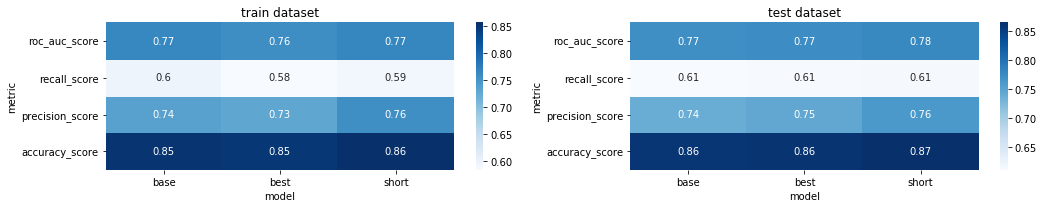

In [45]:
plt.figure(figsize=(15,3))
res_ds = pd.concat([res_ds_base, res_ds_best, res_ds_short])
plt.subplot(121)
cds = res_ds.pivot_table(index=['metric'], columns=['model'], values='train', aggfunc='mean')
sns.heatmap(cds, annot=True, cmap='Blues')
plt.ylim((0,4))
plt.title('train dataset')

plt.subplot(122)
cds = res_ds.pivot_table(index=['metric'], columns=['model'], values='test', aggfunc='mean')
sns.heatmap(cds, annot=True, cmap='Blues')
plt.ylim((0,4))
plt.title('test dataset')

plt.tight_layout()
plt.show()

Сокращённая модель показывает лучший результат и на обучающей, и на тестовой выборках